# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [122]:
#%%pycodestyle
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import os
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
% matplotlib inline
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [123]:
!pip install pycodestyle
!pip install pycodestyle_magic
!pip install pycodestyle flake8 pycodestyle_magic
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [124]:
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    INPUT:
        elem: String that stores a date in the %Y%m%d format
    OUTPUT:
        datetimeobj: Datetime object"""
    return datetime.strptime(str(elem), '%Y%m%d')

In [125]:
'''
portfolio.json

id (string) - offer id
offer_type (string) - type of offer ie BOGO, discount, informational
difficulty (int) - minimum required spend to complete an offer
reward (int) - reward given for completing an offer
duration (int) - time for offer to be open, in days
channels (list of strings)

'''
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [126]:
# No null values in portfolio dataset
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [127]:
'''
profile.json

age (int) - age of the customer
became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer
(note some entries contain 'O' for other rather than M or F)
id (str) - customer id
income (float) - customer's income
'''
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [128]:
profile.isnull().sum()/profile.shape[0]
# Here around 12 percent of gender and income information is missing

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [129]:
gender_dist = profile['gender'].value_counts()
gender_dist.head()*100/gender_dist.sum()

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [130]:
profile[profile['gender'] == 'M'].describe()

,age,became_member_on,income
count,8484.000000,8.484000e+03,8484.000000
mean,52.116690,2.016675e+07,61194.601603
std,17.413894,1.272796e+04,20069.517615
min,18.000000,2.013073e+07,30000.000000
25%,39.000000,2.016043e+07,45000.000000
50%,53.000000,2.017082e+07,59000.000000
75%,65.000000,2.018011e+07,73000.000000
max,100.000000,2.018073e+07,120000.000000


In [131]:
profile[profile['gender'] == 'F'].describe()

,age,became_member_on,income
count,6129.000000,6.129000e+03,6129.000000
mean,57.544950,2.016704e+07,71306.412139
std,16.883315,1.063408e+04,22338.353773
min,18.000000,2.013073e+07,30000.000000
25%,48.000000,2.016061e+07,54000.000000
50%,58.000000,2.017062e+07,71000.000000
75%,69.000000,2.017121e+07,88000.000000
max,101.000000,2.018073e+07,120000.000000


In [132]:
profile[profile['gender'] == 'O'].describe()

,age,became_member_on,income
count,212.000000,2.120000e+02,212.000000
mean,54.400943,2.016790e+07,63287.735849
std,16.244710,1.119045e+04,18938.594726
min,20.000000,2.013092e+07,30000.000000
25%,43.000000,2.016073e+07,51000.000000
50%,55.000000,2.017081e+07,62000.000000
75%,66.000000,2.018011e+07,79250.000000
max,100.000000,2.018072e+07,100000.000000


In [133]:
profile[profile['gender'].isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


In [134]:
profile[~profile['gender'].isnull()].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [135]:
'''
From the distribution above, we can see that the customer profile where
gender is missing is very different from
the customer profile where gender is not missing.
Hence, let's proceed by removing all the customer profile
where gender is missing.
'''

"\nFrom the distribution above, we can see that the customer profile where\ngender is missing is very different from\nthe customer profile where gender is not missing.\nHence, let's proceed by removing all the customer profile\nwhere gender is missing.\n"

In [136]:
profile[profile['income'].isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


In [137]:
profile[profile['income'].isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [138]:
profile[profile['income'].isnull()]['age'].value_counts()

118    2175
Name: age, dtype: int64

In [139]:
profile[profile['income'].isnull()]['gender'].value_counts()

Series([], Name: gender, dtype: int64)

In [140]:
profile[~profile['income'].isnull()].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [141]:
became_member_on = profile['became_member_on'].apply(convert_to_datetime)
became_member_year = became_member_on.apply(lambda elem: elem.year)\
                     .value_counts()
became_member_year *= 100 / became_member_year.sum()
became_member_year

2017    38.052941
2018    24.694118
2016    20.741176
2015    10.764706
2014     4.064706
2013     1.682353
Name: became_member_on, dtype: float64

In [142]:
became_member_month = became_member_on\
                      .apply(lambda elem: elem.month)\
                      .value_counts()
became_member_month *= 100 / became_member_month.sum()
became_member_month

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

In [143]:
became_member_year.value_counts()

1.682353     1
10.764706    1
38.052941    1
4.064706     1
24.694118    1
20.741176    1
Name: became_member_on, dtype: int64

In [144]:
'''
As the population with income and the missing income population
is very different and looks like an outlier set due to missing
age and income.
'''

'\nAs the population with income and the missing income population\nis very different and looks like an outlier set due to missing\nage and income.\n'

In [145]:
'''
transcript.json
event (str) - record description
(ie transaction, offer received, offer viewed, etc.)
person (str) - customer id
time (int) - time in hours since start of test. The data begins at time t=0
value - (dict of strings)
- either an offer id or transaction amount depending on the record
'''
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [146]:
transcript.isnull().sum()
# There are no missing values in transcript

event     0
person    0
time      0
value     0
dtype: int64

In [147]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [148]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [149]:
'''
Let's  explore the customer income distribution based on sex.
'''

"\nLet's  explore the customer income distribution based on sex.\n"

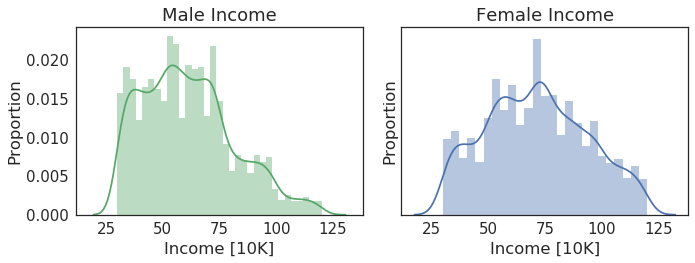

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
male_customers = profile[profile['gender'] == 'M']
female_customers = profile[profile['gender'] == 'F']
current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)
plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('Proportion')
plt.title('Male Income')
plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('Proportion')
plt.title('Female Income')
plt.tight_layout()

In [151]:
'''
Then maximum income in the plots look the same.
However, male income is biased more towards the lower side.
'''

'\nThen maximum income in the plots look the same.\nHowever, male income is biased more towards the lower side.\n'

In [152]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [153]:
became_member_on = profile['became_member_on'].apply(convert_to_datetime)
became_member_year = became_member_on.apply(lambda elem: elem.year)
became_member_month = became_member_on.apply(lambda elem: elem.month)
profile['became_member_year'] = became_member_year
profile['became_member_month'] = became_member_month

In [154]:
membership_date = profile.groupby(['became_member_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['startyear', 'gender', 'count']
membership_date = membership_date[membership_date['gender'] != 'O']

In [155]:
print(membership_date)

    startyear gender  count
0        2013      F     74
1        2013      M    197
3        2014      F    138
4        2014      M    520
6        2015      F    663
7        2015      M    905
9        2016      F   1509
10       2016      M   1483
12       2017      F   2443
13       2017      M   3067
15       2018      F   1302
16       2018      M   2312


Text(0,0.5,'Count')

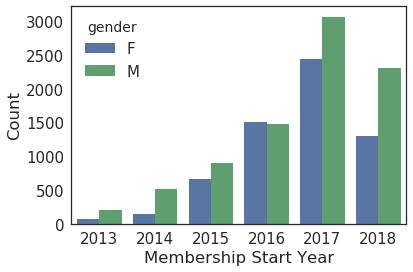

In [156]:
'''
Plotting membership distribution based on membership start year
'''
sns.barplot(x='startyear', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

In [157]:
membership_date.groupby('gender')['count'].sum()

gender
F    6129
M    8484
Name: count, dtype: int64

In [158]:
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)
profile['age_band'] = pd.cut(profile['age'],
                             (range(min_age_limit,
                                    max_age_limit + 10, 10)), right=False)
profile['age_band'] = profile['age_band'].astype('str')

In [159]:
age_range = profile.groupby(['age_band', 'gender']).size()
age_range = age_range.reset_index()
age_range.columns = ['age_band', 'gender', 'count']
age_range = age_range[age_range['gender'] != 'O']

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

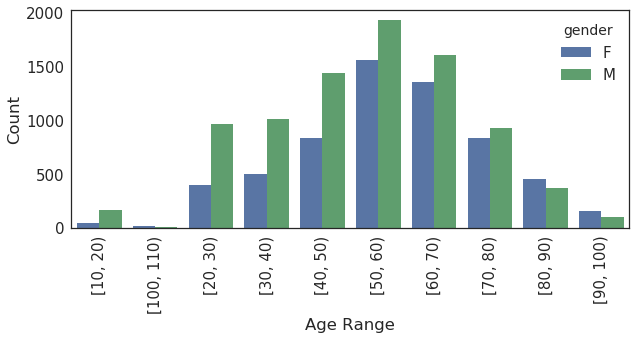

In [160]:
'''
Looking at gender distribution with respect to gender
'''
plt.figure(figsize=(10, 4))
sns.barplot(x='age_band', y='count', hue='gender', data=age_range)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=90)

In [161]:
'''
Let us clean customer profile data
'''

'\nLet us clean customer profile data\n'

In [162]:
def clean_profile(profile):
    '''
    Returns cleaned and transformed profile dataframe
    INPUT:
    profile - Contains customer profile information
    OUTPUT:
    profile - Contains transformed customer profile information.
    '''
    # Extract the year and month
    became_member_on = profile['became_member_on'].apply(convert_to_datetime)
    became_member_year = became_member_on.apply(lambda elem: elem.year)
    # became_member_year *= 100 / became_member_year.sum()
    became_member_month = became_member_on.apply(lambda elem: elem.month)
    # became_member_month *= 100 / became_member_month.sum()
    profile['became_member_year'] = became_member_year
    profile['became_member_month'] = became_member_month
    membershipstartyear_df = pd.get_dummies(profile['became_member_year'])
    membershipstartmonth_df = pd.get_dummies(profile['became_member_month'])
    # One hot encode a customer's age range
    # Drop rows with no income information
    profile.dropna(subset=['income'], how='all', inplace=True)
    min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
    max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)
    profile['age_band'] = pd.cut(profile['age'],
                                 (range(min_age_limit,
                                        max_age_limit + 10, 10)), right=False)
    profile['age_band'] = profile['age_band'].astype('str')
    agerange_df = pd.get_dummies(profile['age_band'])
    profile['gender'] = profile['gender'].replace({'F': 0, 'M': 1, 'O': 2})
    # One-hot encoding gender
    gender_df = pd.get_dummies(profile['gender'])
    gender_df_columns = gender_df.columns.values
    col_names = []
    for elem in gender_df_columns:
        col_names.append('gender'+str(elem))
    gender_df.columns = col_names
    agerange_df_columns = agerange_df.columns.values
    col_names = []
    for elem in agerange_df_columns:
        col_names.append('age_range'+str(elem))
    agerange_df.columns = col_names
    profile = profile.drop(columns=['age',
                                    'age_band',
                                    'became_member_on',
                                    'became_member_year',
                                    'became_member_month',
                                    'gender'], axis=1)
    profile = pd.concat([profile, gender_df, agerange_df], axis=1)
    return profile

In [163]:
profile = clean_profile(profile)

In [164]:
profile.head()

,id,income,gender0,gender1,gender2,"age_range[10, 20)","age_range[100, 110)","age_range[20, 30)","age_range[30, 40)","age_range[40, 50)","age_range[50, 60)","age_range[60, 70)","age_range[70, 80)","age_range[80, 90)","age_range[90, 100)"
1,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,0,0,0,0,1,0,0,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,0,0,0,0,1,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [165]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [166]:
def clean_portfolio(portfolio):
    '''
    Transforms a DataFrame containing offer ids and meta data about
    each offer (duration, type, etc.)
    INPUT:
    portfolio: DataFrame containing offer ids and meta data about
    each offer (duration, type, etc.)
    OUTPUT:
    portfolio: Transformed DataFrame containing offer ids
    and meta data about each offer (duration, type, etc.)
    '''
    # One hot encode offer_type
    offertype_df = pd.get_dummies(portfolio['offer_type'])
    # One hot encode the 'channels' columns
    ml_binarizer_obj = MultiLabelBinarizer()
    ml_binarizer_obj.fit(portfolio['channels'])
    channels_df = pd.DataFrame(ml_binarizer_obj.transform
                               (portfolio['channels']),
                               columns=ml_binarizer_obj.classes_)
    # Concatenating dataframe offertype_df with channels_df and portfolio
    portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)
    portfolio = portfolio.drop(['channels', 'offer_type'], axis=1)
    return portfolio

In [167]:
portfolio = clean_portfolio(portfolio)

In [168]:
portfolio.head()

,difficulty,duration,id,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


In [169]:
# Types of events
event_values = transcript['event'].value_counts()
print(event_values)

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


In [170]:
# Percentage of customer transactions and customer offer events
cust_transactions = transcript[transcript['event'] == 'transaction']\
.shape[0]/transcript.shape[0]*100
print("Percentage of customer transactions", cust_transactions)
cust_offer_events = transcript[transcript['event'] != 'transaction']\
.shape[0]/transcript.shape[0]*100
print("Percentage of customer offer events", cust_offer_events)

Percentage of customer transactions 45.33037118231583
Percentage of customer offer events 54.66962881768417


In [171]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [172]:
def clean_transcript(transcript):
    """
    Transforms a dataframe containing offer data and transaction data
    INPUT:
        transcript: Dataframe containing information
        about offers and transactions
    OUTPUT:
        transcript: Transformed Dataframe containing
        both transactions and offers
        transaction: Transformed Dataframe containing transaction data
        offer_data: Transformed Dataframe containing offer data
        """
    # Remove customer id's that are not in the customer profile DataFrame
    data = transcript['person'].isin(profile['id'])
    transcript = transcript[data]
    # Convert time to days
    transcript['time'] = transcript['time']/24.0
    event_df = pd.get_dummies(transcript['event'])
    # Getting transaction amount from the value column
    transcript['transaction_amount'] = transcript[
        transcript['event'] == 'transaction'][
        'value'].apply(lambda elem: list(elem.values())[0])
    # Getting offer id column
    transcript['offer_id'] = transcript[
        transcript['event'] != 'transaction'][
        'value'].apply(lambda elem: list(elem.values())[0])
    # Create a DataFrame that describes customer offer events
    transcript = pd.concat([transcript, event_df], axis=1)
    # Seperating offer events and transaction events
    transaction = transcript[transcript['event'] == 'transaction']
    offer_data = transcript[transcript['event'] != 'transaction']
    transcript = transcript.drop(columns=['event', 'value'])
    return transcript, transaction, offer_data

In [173]:
transcript, transaction, offer_data = clean_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [174]:
offer_data.head()

,event,person,time,value,transaction_amount,offer_id,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [175]:
transaction.head()

,event,person,time,value,transaction_amount,offer_id,offer completed,offer received,offer viewed,transaction
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,{'amount': 0.8300000000000001},0.83,NaN,0,0,0,1
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,{'amount': 34.56},34.56,NaN,0,0,0,1
12659,transaction,54890f68699049c2a04d415abc25e717,0.0,{'amount': 13.23},13.23,NaN,0,0,0,1
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,{'amount': 19.51},19.51,NaN,0,0,0,1
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,{'amount': 18.97},18.97,NaN,0,0,0,1


In [176]:
def create_combined_records(customer_id, portfolio, profile, transcript):
    """
    Creates a list of dictionaries that describes the effectiveness of
    offers to a specific customer
    INPUT:
        customer_id: String that refers to a specific customer
        profile: DataFrame that contains demographic data for each
        customer
        portfolio: DataFrame containing offer ids and meta data about
        each offer (duration, type, etc.)
        transcript: DataFrame that describes customer
        offer data and transactions
    OUTPUT:
    rows: List of dictionaries that describes the effectiveness of
              offers to a specific customer
    """
    # Select a customer's profile
    cur_customer = profile[profile['id'] == customer_id]

    # Select offer data for a specific customer
    select_offer_data = transcript['person'] == customer_id
    customer_data = transcript[select_offer_data]
    customer_offer_data = customer_data[customer_data['transaction'] == 0]
    customer_transaction_data = customer_data[
        customer_data['transaction'] == 1]
    event_type = ['completed',
                  'received',
                  'viewed']
    offer_received = customer_offer_data[
        customer_offer_data['offer received'] == 1]
    offer_viewed = customer_offer_data[
        customer_offer_data['offer viewed'] == 1]
    offer_completed = customer_offer_data[
        customer_offer_data['offer completed'] == 1]
    # Iterate over each offer a customer receives
    rows = []
    for idx in range(offer_received.shape[0]):
        # Initialize the current offer id
        cur_offer_id = offer_received.iloc[idx]['offer_id']
        # Look-up a description of the current offer
        cur_offer = portfolio.loc[portfolio['id'] == cur_offer_id]
        durationdays = cur_offer['duration'].values[0]
        # Initialize the time period when an offer is valid
        cur_offer_startime = offer_received.iloc[idx]['time']
        cur_offer_endtime = offer_received.iloc[idx]['time'] + durationdays
        # Initialize a boolean array that select customer transcations that
        # fall within the valid offer time window
        select_transaction = np.logical_and(
            customer_transaction_data['time'] >= cur_offer_startime,
            customer_transaction_data['time'] <= cur_offer_endtime)
        '''
        Initialize a boolean array that selects a description of
        when a customer completes an offer
        '''
        select_offer_completed = np.logical_and(
            offer_completed['time'] >= cur_offer_startime,
            offer_completed['time'] <= cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer views an offer
        select_offer_viewed = np.logical_and(
            offer_viewed['time'] >= cur_offer_startime,
            offer_viewed['time'] <= cur_offer_endtime)

        # Determine whether the current offer was successful
        cur_offer_successful = select_offer_completed.sum() > 0 and
        select_offer_viewed.sum() > 0
        cur_offer_transactions = customer_transaction_data[select_transaction]
        # Initialize a dictionary that describes the current customer offer
        cur_row = {'offerid': cur_offer_id,
                   'customerid': customer_id,
                   'time': cur_offer_startime,
                   'offersuccessful': int(cur_offer_successful),
                   'totalamount': cur_offer_transactions[
                       'transaction_amount'].sum()}
        cur_row.update(cur_offer.iloc[0, :].to_dict())
        cur_row.update(cur_customer.iloc[0, :].to_dict())
        # Update a list of dictionaries that describes the effectiveness of
        # offers to a specific customer
        rows.append(cur_row)
    return rows

SyntaxError: invalid syntax (<ipython-input-176-cc761e088348>, line 66)

In [177]:
def create_offeranalysis_dataset(profile, portfolio, transcript):
    """ Creates an analytic dataset from the following
    Starbucks challenge datasets:
    * portfolio.json - Contains offer ids and meta data (duration, type,
                       etc.)
    * profile.json - demographic data for each customer
    * transcript.json - records for transactions, offers received, offers
                        viewed, and offers completed
    INPUT:
    profile: DataFrame that contains demographic data for each
    customer
    portfolio: Contains offer ids and meta data (duration, type, etc.)
    transcript: DataFrame that describes customer
    offer data and transaction data
    OUTPUT:
    clean_data: DataFrame that characterizes the effectiveness of
    customer offers"""
    clean_data = []
    customerid_list = transcript['person'].unique()
    for idx in range(0, len(customerid_list)):
        clean_data.extend(create_combined_records(
            customerid_list[idx], portfolio, profile, transcript))
    clean_data = pd.DataFrame(clean_data)
    clean_data = clean_data.sort_values('time')
    return clean_data.reset_index(drop=True)

In [178]:
select_offer_data = transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef'

In [179]:
transcript.head()

,person,time,transaction_amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [180]:
clean_data_csvfile = "./data/clean_datafinalv1.csv"

if os.path.exists(clean_data_csvfile):
    clean_data = pd.read_csv(clean_data_csvfile)
else:
    clean_data = create_offeranalysis_dataset(profile,
                                              portfolio,
                                              transcript)

    clean_data.to_csv(clean_data_csvfile, index=False)

In [181]:
clean_data.shape

(66501, 30)

In [182]:
clean_data.head()

,"age_range[10, 20)","age_range[100, 110)","age_range[20, 30)","age_range[30, 40)","age_range[40, 50)","age_range[50, 60)","age_range[60, 70)","age_range[70, 80)","age_range[80, 90)","age_range[90, 100)",...,income,informational,mobile,offerid,offersuccessful,reward,social,time,totalamount,web
0,0,0,0,0,0,0,0,1,0,0,...,100000.0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0,0.0,37.67,1
1,0,0,0,0,0,0,1,0,0,0,...,92000.0,1,1,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0.0,23.30,0
2,0,0,0,0,0,1,0,0,0,0,...,49000.0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,0,0.0,0.00,1
3,0,0,0,0,0,0,0,1,0,0,...,87000.0,1,1,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0.0,0.00,0
4,0,0,0,0,0,0,1,0,0,0,...,89000.0,0,1,ae264e3637204a6fb9bb56bc8210ddfd,1,10,1,0.0,27.96,0


In [183]:
clean_data.columns

Index(['age_range[10, 20)', 'age_range[100, 110)', 'age_range[20, 30)',
       'age_range[30, 40)', 'age_range[40, 50)', 'age_range[50, 60)',
       'age_range[60, 70)', 'age_range[70, 80)', 'age_range[80, 90)',
       'age_range[90, 100)', 'bogo', 'customerid', 'difficulty', 'discount',
       'duration', 'email', 'gender0', 'gender1', 'gender2', 'id', 'income',
       'informational', 'mobile', 'offerid', 'offersuccessful', 'reward',
       'social', 'time', 'totalamount', 'web'],
      dtype='object')

In [184]:
portfolio.head()

,difficulty,duration,id,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


In [185]:
profile.head()

,id,income,gender0,gender1,gender2,"age_range[10, 20)","age_range[100, 110)","age_range[20, 30)","age_range[30, 40)","age_range[40, 50)","age_range[50, 60)","age_range[60, 70)","age_range[70, 80)","age_range[80, 90)","age_range[90, 100)"
1,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,0,0,0,0,1,0,0,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,0,0,0,0,1,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [186]:
'''
Splitting data into test and training data sets
'''

'\nSplitting data into test and training data sets\n'

In [187]:
clean_data.columns

Index(['age_range[10, 20)', 'age_range[100, 110)', 'age_range[20, 30)',
       'age_range[30, 40)', 'age_range[40, 50)', 'age_range[50, 60)',
       'age_range[60, 70)', 'age_range[70, 80)', 'age_range[80, 90)',
       'age_range[90, 100)', 'bogo', 'customerid', 'difficulty', 'discount',
       'duration', 'email', 'gender0', 'gender1', 'gender2', 'id', 'income',
       'informational', 'mobile', 'offerid', 'offersuccessful', 'reward',
       'social', 'time', 'totalamount', 'web'],
      dtype='object')

In [188]:
clean_data = clean_data[['offerid', 'totalamount', 'age_range[10, 20)',
                         'age_range[100, 110)', 'age_range[20, 30)',
                         'age_range[30, 40)', 'age_range[40, 50)',
                         'age_range[50, 60)', 'age_range[60, 70)',
                         'age_range[70, 80)', 'age_range[80, 90)',
                         'age_range[90, 100)', 'bogo', 'customerid',
                         'discount', 'duration', 'email', 'gender0',
                         'gender1', 'gender2', 'income',
                         'informational', 'mobile', 'offersuccessful',
                         'reward', 'social', 'time', 'web', 'difficulty']]

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
successful_offers = clean_data[clean_data['offersuccessful'] == 1]
unsuccessful_offers = clean_data[clean_data['offersuccessful'] == 0]
bogo = clean_data[
    (clean_data['offersuccessful'] == 1) & (
        clean_data['bogo'] == 1)].shape[0]/clean_data[
    clean_data['bogo'] == 1].shape[0]
informational = clean_data[
    (clean_data['offersuccessful'] == 1) &
    (clean_data['informational'] == 1)].shape[0]/\
clean_data[clean_data['informational'] == 1].shape[0]
discount = clean_data[
    (clean_data['offersuccessful'] == 1) &
    (clean_data['discount'] == 1)].shape[0]/\
clean_data[clean_data['discount'] == 1].shape[0]

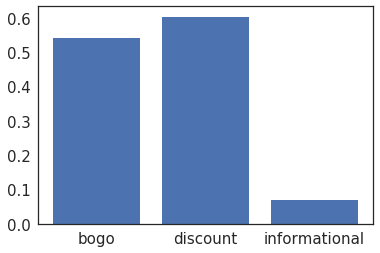

In [192]:
'''
This graph shows the success rate of bogo,
informational and discount type of messages
'''
import matplotlib.pyplot as plt
X = [bogo, informational, discount]
Y = ['bogo', 'informational', 'discount']
plt.bar(Y, X)
plt.show()

In [193]:
clean_data[['offerid', 'customerid']].head()

,offerid,customerid
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef
1,5a8bc65990b245e5a138643cd4eb9837,d1485166e0f44d2f8be9ee8c4a06a026
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,9e0d618d75954225adc8cff0c3e420e8
3,5a8bc65990b245e5a138643cd4eb9837,aa374a0deb7743aa9505b6611f350b09
4,ae264e3637204a6fb9bb56bc8210ddfd,44f1f503047642ac83f70785c4992032


In [195]:
random_state = 3154220327
label_name = 'offersuccessful'
variables = clean_data.drop(columns=[label_name, 'customerid'])
class_label = clean_data.filter([label_name])
(X_train, X_test, y_train, y_test) = \
train_test_split(variables.values,
                 class_label.values,
                 test_size=0.2,
                 random_state=random_state)
variable_names = variables.columns[2:]
offerid_train = X_train[:, 0]
totalamount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')
offerid_test = X_test[:, 0]
totalamount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')
y_train = y_train.ravel()
y_test = y_test.ravel()

In [196]:
training_variables = pd.DataFrame(X_train, columns=variable_names)
training_labels = pd.DataFrame(y_train, columns=[label_name])
training_offerid = pd.DataFrame(offerid_train, columns=['offerid'])

training_data = pd.concat([training_offerid,
                           training_variables,
                           training_labels], axis=1)

training_data = training_data.drop(columns=['difficulty', 'duration',
                                            'reward', 'bogo', 'discount',
                                            'mobile', 'social', 'web'])

training_data.head()

,offerid,"age_range[10, 20)","age_range[100, 110)","age_range[20, 30)","age_range[30, 40)","age_range[40, 50)","age_range[50, 60)","age_range[60, 70)","age_range[70, 80)","age_range[80, 90)","age_range[90, 100)",email,gender0,gender1,gender2,income,informational,time,offersuccessful
0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,98000.0,0.0,14.0,1
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,62000.0,0.0,24.0,0
2,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,42000.0,0.0,17.0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,78000.0,0.0,24.0,0
4,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,76000.0,0.0,21.0,1


In [197]:
training_data.columns

Index(['offerid', 'age_range[10, 20)', 'age_range[100, 110)',
       'age_range[20, 30)', 'age_range[30, 40)', 'age_range[40, 50)',
       'age_range[50, 60)', 'age_range[60, 70)', 'age_range[70, 80)',
       'age_range[80, 90)', 'age_range[90, 100)', 'email', 'gender0',
       'gender1', 'gender2', 'income', 'informational', 'time',
       'offersuccessful'],
      dtype='object')

In [198]:
portfolio.head()

,difficulty,duration,id,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


In [199]:
'''
Here we are scaling the features diificulty, duration, reward and income

'''

'\nHere we are scaling the features diificulty, duration, reward and income\n\n'

In [217]:
variables_to_scale = ['difficulty', 'duration', 'reward', 'income']

min_max_scaler = {}

for idx in range(len(variables_to_scale)):
    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]
    cur_column = variables_to_scale[idx]
    min_max_scaler[cur_column] = MinMaxScaler()
    min_max_scaler[cur_column].fit(X_train[:, column_idx].reshape(-1, 1))
    transformed_values = min_max_scaler[cur_column].\
    transform(X_train[:, column_idx].reshape(-1, 1))
    X_train[:, column_idx] = transformed_values.reshape(1, -1)
    transformed_values = min_max_scaler[cur_column].\
    transform(X_test[:, column_idx].reshape(-1, 1))
    X_test[:, column_idx] = transformed_values.reshape(1, -1)

In [218]:
portfolio = portfolio.rename(index=str, columns={"id": "offerid"})

In [219]:
def get_success(portfolio, clean_data):
    """ Initializes a DataFrame that describes the success rate for each offer
    INPUT:
    portfolio: DataFrame containing offer ids and meta data about
    each offer (duration, type, etc.)
    clean_data: DataFrame that characterizes the effectiveness of
    customer offers
    OUTPUT:
    success: DataFrame that describes the success rate for each offer"""
    successful_count = clean_data[
        ['offerid', 'offersuccessful']].groupby('offerid').sum().reset_index()
    print(successful_count.head())
    offer_count = clean_data['offerid'].value_counts()
    offer_count = pd.DataFrame(list(zip(
        offer_count.index.values, offer_count.values)),
                               columns=['offerid', 'count'])
    successful_count = successful_count.sort_values('offerid')
    offer_count = offer_count.sort_values('offerid')
    success = pd.merge(offer_count, successful_count, on="offerid")
    success['percentsuccess'] = 100 * success[
        'offersuccessful'] / success['count']
    success = pd.merge(success, portfolio, on="offerid")
    success = success.drop(columns=['offersuccessful'])
    success = success.sort_values('percentsuccess', ascending=False)
    return success.reset_index(drop=True)

In [220]:
success = get_success(portfolio, training_data)

                            offerid  offersuccessful
0  0b1e1539f2cc45b7b9fa7c272da2e1d7             2475
1  2298d6c36e964ae4a3e7e9706d1fb8c2             3883
2  2906b810c7d4411798c6938adc9daaa5             2569
3  3f207df678b143eea3cee63160fa8bed              419
4  4d5c57ea9a6940dd891ad53e9dbe8da0             2733


In [221]:
success

,offerid,count,percentsuccess,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,fafdcd668e3743c1bb461111dcafc2a4,5254,74.990483,10,10,2,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,5325,72.920188,7,7,3,0,1,0,1,1,1,1
2,f19421c1d4aa40978ebb69ca19b0e20d,5252,62.109673,5,5,5,1,0,0,1,1,1,1
3,ae264e3637204a6fb9bb56bc8210ddfd,5357,54.676125,10,7,10,1,0,0,1,1,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,5305,51.517436,10,5,10,1,0,0,1,1,1,1
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5346,48.279087,5,7,5,1,0,0,1,1,0,1
6,2906b810c7d4411798c6938adc9daaa5,5371,47.830944,10,7,2,0,1,0,1,1,0,1
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,5366,46.123742,20,10,5,0,1,0,1,0,0,1
8,3f207df678b143eea3cee63160fa8bed,5299,7.907152,0,4,0,0,0,1,1,1,0,1
9,5a8bc65990b245e5a138643cd4eb9837,5325,6.347418,0,3,0,0,0,1,1,1,1,0


In [222]:
'''
Generating plots of success rate and offer frequency
'''

'\nGenerating plots of success rate and offer frequency\n'

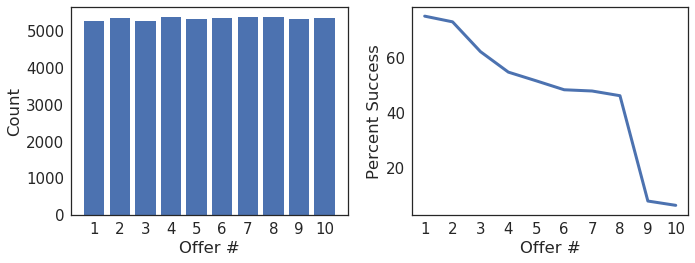

In [223]:
fig, axis = plt.subplots(figsize=(10, 4),
                         nrows=1,
                         ncols=2)
axis[0].bar(success.index + 1, success['count'])
axis[0].set_xticks(np.arange(0, 10) + 1)
axis[0].set_xlabel('Offer #')
axis[0].set_ylabel('Count')
axis[1].plot(success.index + 1,
             success['percentsuccess'],
             linewidth=3)
axis[1].set_xticks(
    np.arange(0, 10) + 1)
axis[1].set_xlabel('Offer #')
axis[1].set_ylabel('Percent Success')
plt.tight_layout()

# Predicting offer success

## Here we are using different classifiers to evaluate their performance

Hence, I have used a naive predictor to compare the performance of various machine learning algorithms


In [224]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.4f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.4f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.4723
Naive predictor f1-score: 0.6416


### Logistic Regression

In [225]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
lr_model_path = os.path.join(model_dir, 'clf_lr.job')
scorer = make_scorer(fbeta_score, beta=0.5)

if os.path.exists(lr_model_path):
    lr_random = load(lr_model_path)
else:
    lr_clf = LogisticRegression(random_state=random_state, solver='liblinear')
    random_grid = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}
    lr_random = RandomizedSearchCV(estimator=lr_clf,
                                   param_distributions=random_grid,
                                   scoring=scorer,
                                   n_iter=6,
                                   cv=3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs=3)
    lr_random.fit(X_train, y_train)
    dump(lr_random, lr_model_path)

In [226]:
def evaluate_model_performance(clf, X_train, y_train):
    """ Displays a model's accuracy and F1-score
    INPUT:
        clf: Classifier
        X_train: Training dataset
        y_train: Testing dataset
    OUTPUT:
        clf_accuracy: Model accuracy
        clf_f1_score: Model F1-score"""
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]
    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    return clf_accuracy, clf_f1_score

In [227]:
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.701
LogisticRegression model f1-score: 0.699


(0.70054511278195486, 0.69919374634164766)

### Random Forest

In [228]:
rf_model_path = os.path.join(model_dir, 'clf_rf.job')

if os.path.exists(rf_model_path):
    rf_random = load(rf_model_path)
else:
    rf_clf = RandomForestClassifier(random_state=random_state)
    n_estimators = [20, 50, 100, 150, 200]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.arange(5, 10)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4, 6]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(estimator=rf_clf,
                                   param_distributions=random_grid,
                                   scoring=scorer,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs=3)

    rf_random.fit(X_train, y_train)
    dump(rf_random, rf_model_path)


In [229]:
evaluate_model_performance(rf_random.best_estimator_,  X_train, y_train)

RandomForestClassifier model accuracy: 0.719
RandomForestClassifier model f1-score: 0.727


(0.71913533834586463, 0.7274252982596956)

Text(0.5,1,'Random Forest Estimated Feature Importance')

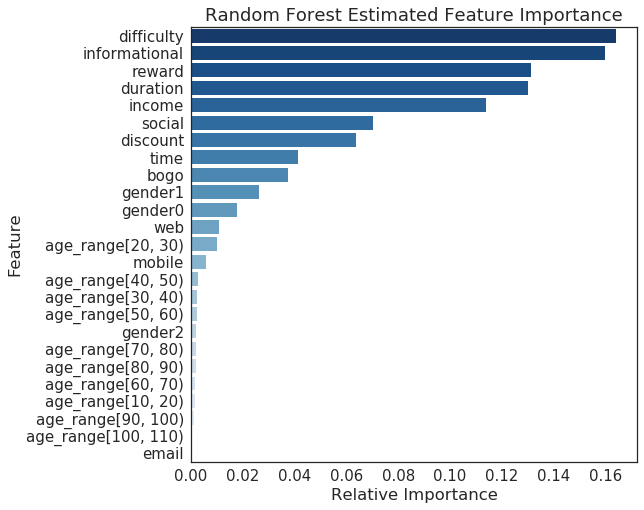

In [230]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance = pd.DataFrame(list(zip(
    variable_names, relative_importance)),
                                  columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

In [231]:
feature_importance.head(10)

,feature,relativeimportance
0,difficulty,0.164236
1,informational,0.159996
2,reward,0.131508
3,duration,0.130302
4,income,0.113776
5,social,0.070235
6,discount,0.063655
7,time,0.041201
8,bogo,0.037267
9,gender1,0.026191


### Geadient Boosting Classifier

In [232]:
gb_model_path = os.path.join(model_dir, 'gb_clf.joblib')

if os.path.exists(gb_model_path):
    clf_gbm = load(gb_model_path)
else:
    gb_clf = GradientBoostingClassifier(random_state=random_state)
    random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 50, 100, 150, 200, 250, 300],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_samples_split}
    clf_gbm = RandomizedSearchCV(estimator=gb_clf,
                                 param_distributions=random_grid,
                                 scoring=scorer,
                                 n_iter=100,
                                 cv=3,
                                 verbose=2,
                                 random_state=random_state,
                                 n_jobs=3)
    clf_gbm.fit(X_train, y_train)
    dump(clf_gbm, gb_model_path)

In [233]:
evaluate_model_performance(clf_gbm.best_estimator_, X_train, y_train)

GradientBoostingClassifier model accuracy: 0.716
GradientBoostingClassifier model f1-score: 0.720


(0.71624060150375934, 0.72033050502056395)

## Evaluating performance of machine learning algorithms

### Gradient Boosting Model

#### Accuracy - 71.6%   F1-Score - 72%

### Random Forest Model

#### Accuracy -  71.9%    F1-Score - 72.7%

### Logistic Regression Model

#### Accuracy -  70.1%  F1-Score -  69.9%

### Naive Predictor

#### Accuracy -  47.2%  F1-Score -  67.6%

#### Here, we can see that the best performer is Random Forest Model.

#### Also, the five most important features contributing to success of the offers is difficulty, whether offer is informational, whether offer is reward, duration of the offer and income of the customer.
